# Customer Feature Engineering

This notebook implements customer feature engineering for the H&M dataset, including:

- RFM Analysis (Recency, Frequency, Monetary)
- Purchase diversity score
- Price sensitivity index
- Colour preference entropy
- Style consistency score

The engineered features will later be used for customer segmentation and behavioural analysis.


## 1. Setup and Imports


In [1]:
# Add project root to path
import sys
sys.path.append('../')

# Core imports
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Project imports
from hnm_data_analysis.feature_engineering.customer_features import CustomerFeatures
from hnm_data_analysis.data_understanding.data_report_generator import generate_data_report

# Configuration
plt.style.use('seaborn-v0_8')
pl.Config.set_tbl_rows(10)
pl.Config.set_tbl_cols(15)

print("Setup complete!")
print(f"Polars version: {pl.__version__}")
print(f"Working directory: {Path.cwd()}")

Setup complete!
Polars version: 1.32.0
Working directory: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/notebooks


## 2. Data Loading and Initial Exploration

Let's examine the structure of our cleaned datasets before feature engineering.


In [2]:
# Load cleaned datasets for exploration
customers_path = "../data/cleaned/customers_cleaned.parquet"
transactions_path = "../data/cleaned/transactions_cleaned.parquet"
articles_path = "../data/features/final/articles_features_final.parquet"

# Check file existence
for path in [customers_path, transactions_path, articles_path]:
    if not Path(path).exists():
        print(f"⚠️  Warning: {path} not found")
    else:
        print(f"✅ {path} found")

print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)

✅ ../data/cleaned/customers_cleaned.parquet found
✅ ../data/cleaned/transactions_cleaned.parquet found
✅ ../data/features/final/articles_features_final.parquet found

DATASET OVERVIEW


In [3]:
# Load and examine customers data
customers_df = pl.read_parquet(customers_path)

print("📊 CUSTOMERS DATASET")
print(f"Shape: {customers_df.shape}")
print(f"Columns: {list(customers_df.columns)}")
print("\nSchema:")
print(customers_df.schema)
print("\nSample data:")
customers_df.head(3)

📊 CUSTOMERS DATASET
Shape: (525075, 14)
Columns: ['customer_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'FN_imputed', 'Active_imputed', 'club_member_status_imputed', 'fashion_news_frequency_imputed', 'age_imputed', 'postal_code_imputed', 'age_corrected']

Schema:
Schema([('customer_id', String), ('FN', Float64), ('Active', Float64), ('club_member_status', Categorical(Categories(""))), ('fashion_news_frequency', Categorical(Categories(""))), ('age', Float64), ('postal_code', Categorical(Categories(""))), ('FN_imputed', Boolean), ('Active_imputed', Boolean), ('club_member_status_imputed', Boolean), ('fashion_news_frequency_imputed', Boolean), ('age_imputed', Boolean), ('postal_code_imputed', Boolean), ('age_corrected', Boolean)])

Sample data:


customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,FN_imputed,Active_imputed,club_member_status_imputed,fashion_news_frequency_imputed,age_imputed,postal_code_imputed,age_corrected
str,f64,f64,cat,cat,f64,cat,bool,bool,bool,bool,bool,bool,bool
"""438607b2b3aac3e702db0f5b3c4671…",1.0,1.0,"""ACTIVE""","""Regularly""",50.0,"""27602626831e85a1a8945906f565f0…",false,false,false,false,false,false,false
"""13233aed650830ba4a6334767848bb…",0.0,0.0,"""ACTIVE""","""NONE""",28.0,"""a8b29ddf414ee0011f4130349551cd…",true,true,false,false,false,false,false
"""88962d49bd663778682892f9c49a64…",1.0,1.0,"""ACTIVE""","""Regularly""",21.0,"""a6cb86a4267472204455c76018edb3…",false,false,false,false,false,false,false


In [4]:
# Load and examine transactions data
transactions_df = pl.read_parquet(transactions_path)

print("📊 TRANSACTIONS DATASET")
print(f"Shape: {transactions_df.shape}")
print(f"Columns: {list(transactions_df.columns)}")
print("\nSchema:")
print(transactions_df.schema)
print("\nDate range:")
print(transactions_df.select([pl.col("t_dat").min().alias("min_date"), 
                             pl.col("t_dat").max().alias("max_date")]))
print("\nSample data:")
transactions_df.head(3)

📊 TRANSACTIONS DATASET
Shape: (3904391, 8)
Columns: ['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id', 'price_outlier_capped', 'sales_channel_corrected', 'price_percentile_calibrated']

Schema:
Schema([('t_dat', Date), ('customer_id', String), ('article_id', Int64), ('price', Float64), ('sales_channel_id', Int64), ('price_outlier_capped', Boolean), ('sales_channel_corrected', Boolean), ('price_percentile_calibrated', Boolean)])

Date range:
shape: (1, 2)
┌────────────┬────────────┐
│ min_date   ┆ max_date   │
│ ---        ┆ ---        │
│ date       ┆ date       │
╞════════════╪════════════╡
│ 2020-06-24 ┆ 2020-09-22 │
└────────────┴────────────┘

Sample data:


t_dat,customer_id,article_id,price,sales_channel_id,price_outlier_capped,sales_channel_corrected,price_percentile_calibrated
date,str,i64,f64,i64,bool,bool,bool
2020-06-24,"""0001b0127d3e5ff8dadcfc6e504368…",844409002,14.33,1,false,false,true
2020-06-24,"""0001b0127d3e5ff8dadcfc6e504368…",876053003,21.35,1,false,false,true
2020-06-24,"""000493dd9fc463df1acc2081450c9e…",831269004,11.32,1,false,false,true


In [5]:
# Load and examine articles data
articles_df = pl.read_parquet(articles_path)

print("📊 ARTICLES DATASET")
print(f"Shape: {articles_df.shape}")
print(f"Columns: {list(articles_df.columns)}")
print("\nSchema:")
print(articles_df.schema)
print("\nSample data:")
articles_df.head(3)

📊 ARTICLES DATASET
Shape: (42298, 14)
Columns: ['article_id', 'product_type_name', 'product_group_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name', 'perceived_colour_master_name', 'department_name', 'index_name', 'index_group_name', 'section_name', 'garment_group_name', 'detail_desc', 'bert_cluster']

Schema:
Schema([('article_id', Int64), ('product_type_name', Categorical), ('product_group_name', Categorical), ('graphical_appearance_name', Categorical), ('colour_group_name', Categorical), ('perceived_colour_value_name', Categorical), ('perceived_colour_master_name', Categorical), ('department_name', Categorical), ('index_name', Categorical), ('index_group_name', Categorical), ('section_name', Categorical), ('garment_group_name', Categorical), ('detail_desc', Categorical), ('bert_cluster', Int64)])

Sample data:


article_id,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc,bert_cluster
i64,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,cat,i64
652356082,"""Underwear bottom""","""Underwear""","""All over pattern""","""Orange""","""Dusty Light""","""Orange""","""Underwear Woven""","""Menswear""","""Menswear""","""Men Underwear""","""Under-, Nightwear""","""Boxer shorts in a cotton weave…",10
212629004,"""Dress""","""Garment Full body""","""Solid""","""Black""","""Dark""","""Black""","""Basic 1""","""Divided""","""Divided""","""Divided Basics""","""Jersey Basic""","""Long, sleeveless dress in jers…",28
619601011,"""Robe""","""Underwear""","""Mixed solid/pattern""","""Light Yellow""","""Light""","""Yellow""","""Kids Girl UW/NW""","""Children Sizes 92-140""","""Baby/Children""","""Girls Underwear & Basics""","""Under-, Nightwear""","""Dressing gown in terry with a …",29


## 3. Customer Feature Engineering

Now we'll use our CustomerFeatures class to engineer customer behavioural features.


In [6]:
# Configuration for feature engineering
# Set sample_size=None for full dataset processing, or specify a number for testing
SAMPLE_SIZE = None  # Change to e.g., 10000 for testing with smaller dataset
BATCH_SIZE = 50000  # Batch size for memory-efficient processing

print("🔧 CUSTOMER FEATURE ENGINEERING CONFIGURATION")
print(f"Sample size: {SAMPLE_SIZE if SAMPLE_SIZE else 'Full dataset'}")
print(f"Batch size: {BATCH_SIZE}")
print("\nInitialising CustomerFeatures class...")

# Initialise feature engineer
feature_engineer = CustomerFeatures(
    customers_path=customers_path,
    transactions_path=transactions_path,
    articles_path=articles_path,
    batch_size=BATCH_SIZE,
    sample_size=SAMPLE_SIZE
)

print("✅ CustomerFeatures initialised successfully!")

🔧 CUSTOMER FEATURE ENGINEERING CONFIGURATION
Sample size: Full dataset
Batch size: 50000

Initialising CustomerFeatures class...
✅ CustomerFeatures initialised successfully!


In [7]:
# Engineer customer features
print("🚀 Starting customer feature engineering...")
print("This may take several minutes for the full dataset.\n")

# Create output directory
output_dir = Path("../data/features/final")
output_dir.mkdir(parents=True, exist_ok=True)

# Engineer features (this will handle all the complex calculations)
customer_features = feature_engineer.engineer_customer_features(
    output_path="../data/features/final/customer_features_final.parquet"
)

print(f"\n✅ Feature engineering complete!")
print(f"Final features shape: {customer_features.shape}")
print(f"Features saved to: ../data/features/final/customer_features_final.parquet")

INFO:hnm_data_analysis.feature_engineering.customer_features:Starting customer feature engineering pipeline...
INFO:hnm_data_analysis.feature_engineering.customer_features:Loading datasets...


🚀 Starting customer feature engineering...
This may take several minutes for the full dataset.



INFO:hnm_data_analysis.feature_engineering.customer_features:Reference date for recency: 2020-09-23
INFO:hnm_data_analysis.feature_engineering.customer_features:Loaded: 525075 customers, 3904391 transactions, 42298 articles
INFO:hnm_data_analysis.feature_engineering.customer_features:Calculating individual feature sets...
INFO:hnm_data_analysis.feature_engineering.customer_features:Calculating RFM features...
INFO:hnm_data_analysis.feature_engineering.customer_features:Price range: £2.39 - £149.99
INFO:hnm_data_analysis.feature_engineering.customer_features:99th percentile: £149.99
INFO:hnm_data_analysis.feature_engineering.customer_features:Customer frequency max: 350 (99th percentile: 43)
INFO:hnm_data_analysis.feature_engineering.customer_features:Customer monetary max: £19342.12 (99th percentile: £1416.85)
INFO:hnm_data_analysis.feature_engineering.customer_features:Calculating purchase diversity scores...
INFO:hnm_data_analysis.feature_engineering.customer_features:Calculating pri


✅ Feature engineering complete!
Final features shape: (525075, 10)
Features saved to: ../data/features/final/customer_features_final.parquet


In [8]:
# Display engineered features
print("📋 ENGINEERED CUSTOMER FEATURES")
print(f"Total customers: {customer_features.height:,}")
print(f"Total features: {customer_features.width}")
print(f"\nFeature columns:")
for i, col in enumerate(customer_features.columns, 1):
    print(f"{i:2d}. {col}")

print("\nSample of engineered features:")
customer_features.head(5)

📋 ENGINEERED CUSTOMER FEATURES
Total customers: 525,075
Total features: 10

Feature columns:
 1. customer_id
 2. recency
 3. frequency
 4. monetary
 5. purchase_diversity_score
 6. price_sensitivity_index
 7. colour_preference_entropy
 8. style_consistency_score
 9. features_created_at
10. rfm_reference_date

Sample of engineered features:


customer_id,recency,frequency,monetary,purchase_diversity_score,price_sensitivity_index,colour_preference_entropy,style_consistency_score,features_created_at,rfm_reference_date
str,i64,u32,f64,f64,f64,f64,f64,str,str
"""438607b2b3aac3e702db0f5b3c4671…",24,6,112.07,1.792481,0.808535,1.792481,0.030276,"""2025-08-16T09:44:23.817002""","""2020-09-23"""
"""13233aed650830ba4a6334767848bb…",5,5,161.31,0.0,0.244477,1.370951,0.278072,"""2025-08-16T09:44:23.817002""","""2020-09-23"""
"""88962d49bd663778682892f9c49a64…",58,11,227.68,1.789929,0.592714,2.222192,0.05123,"""2025-08-16T09:44:23.817002""","""2020-09-23"""
"""2f30997f9a1988109eea3129327865…",32,1,29.99,0.0,0.0,0.0,1.0,"""2025-08-16T09:44:23.817002""","""2020-09-23"""
"""2428001c86ac0a9184048c0dad90cf…",62,7,109.4,0.0,0.734895,2.235926,1.0,"""2025-08-16T09:44:23.817002""","""2020-09-23"""


## 4. Feature Analysis and Validation

Let's analyse the distribution and characteristics of our engineered features.


In [9]:
# Generate feature summary
print("📊 GENERATING FEATURE SUMMARY STATISTICS...")

feature_summary = feature_engineer.generate_feature_summary(customer_features)

print("\n" + "="*60)
print("CUSTOMER FEATURE SUMMARY")
print("="*60)
print(f"Total customers processed: {feature_summary['total_customers']:,}")
print(f"Active customers (with purchases): {feature_summary['active_customers']:,}")
print(f"Active customer rate: {feature_summary['active_customer_rate']:.1%}")
print(f"Reference date for RFM: {feature_summary['reference_date']}")

print("\n📈 FEATURE STATISTICS:")
for feature_name, stats in feature_summary['feature_statistics'].items():
    print(f"\n{feature_name.upper()}:")
    print(f"  Mean: {stats['mean']:.3f}")
    print(f"  Median: {stats['median']:.3f}")
    print(f"  Std Dev: {stats['std']:.3f}")
    print(f"  Range: [{stats['min']:.3f}, {stats['max']:.3f}]")
    print(f"  Null Count: {stats['null_count']}")

INFO:hnm_data_analysis.feature_engineering.customer_features:Generating feature summary statistics...


📊 GENERATING FEATURE SUMMARY STATISTICS...

CUSTOMER FEATURE SUMMARY
Total customers processed: 525,075
Active customers (with purchases): 525,075
Active customer rate: 100.0%
Reference date for RFM: 2020-09-23

📈 FEATURE STATISTICS:

RECENCY:
  Mean: 38.542
  Median: 34.000
  Std Dev: 26.833
  Range: [1.000, 91.000]
  Null Count: 0

FREQUENCY:
  Mean: 7.436
  Median: 5.000
  Std Dev: 9.059
  Range: [1.000, 350.000]
  Null Count: 0

MONETARY:
  Mean: 199.568
  Median: 104.920
  Std Dev: 300.545
  Range: [2.390, 19342.120]
  Null Count: 0

PURCHASE_DIVERSITY_SCORE:
  Mean: 0.956
  Median: 1.000
  Std Dev: 0.749
  Range: [0.000, 3.140]
  Null Count: 0

PRICE_SENSITIVITY_INDEX:
  Mean: 0.465
  Median: 0.434
  Std Dev: 0.364
  Range: [0.000, 2.793]
  Null Count: 0

COLOUR_PREFERENCE_ENTROPY:
  Mean: 1.445
  Median: 1.500
  Std Dev: 0.985
  Range: [0.000, 4.747]
  Null Count: 0

STYLE_CONSISTENCY_SCORE:
  Mean: 0.331
  Median: 0.098
  Std Dev: 0.410
  Range: [0.000, 1.000]
  Null Count: 0


📊 FEATURE DISTRIBUTION ANALYSIS



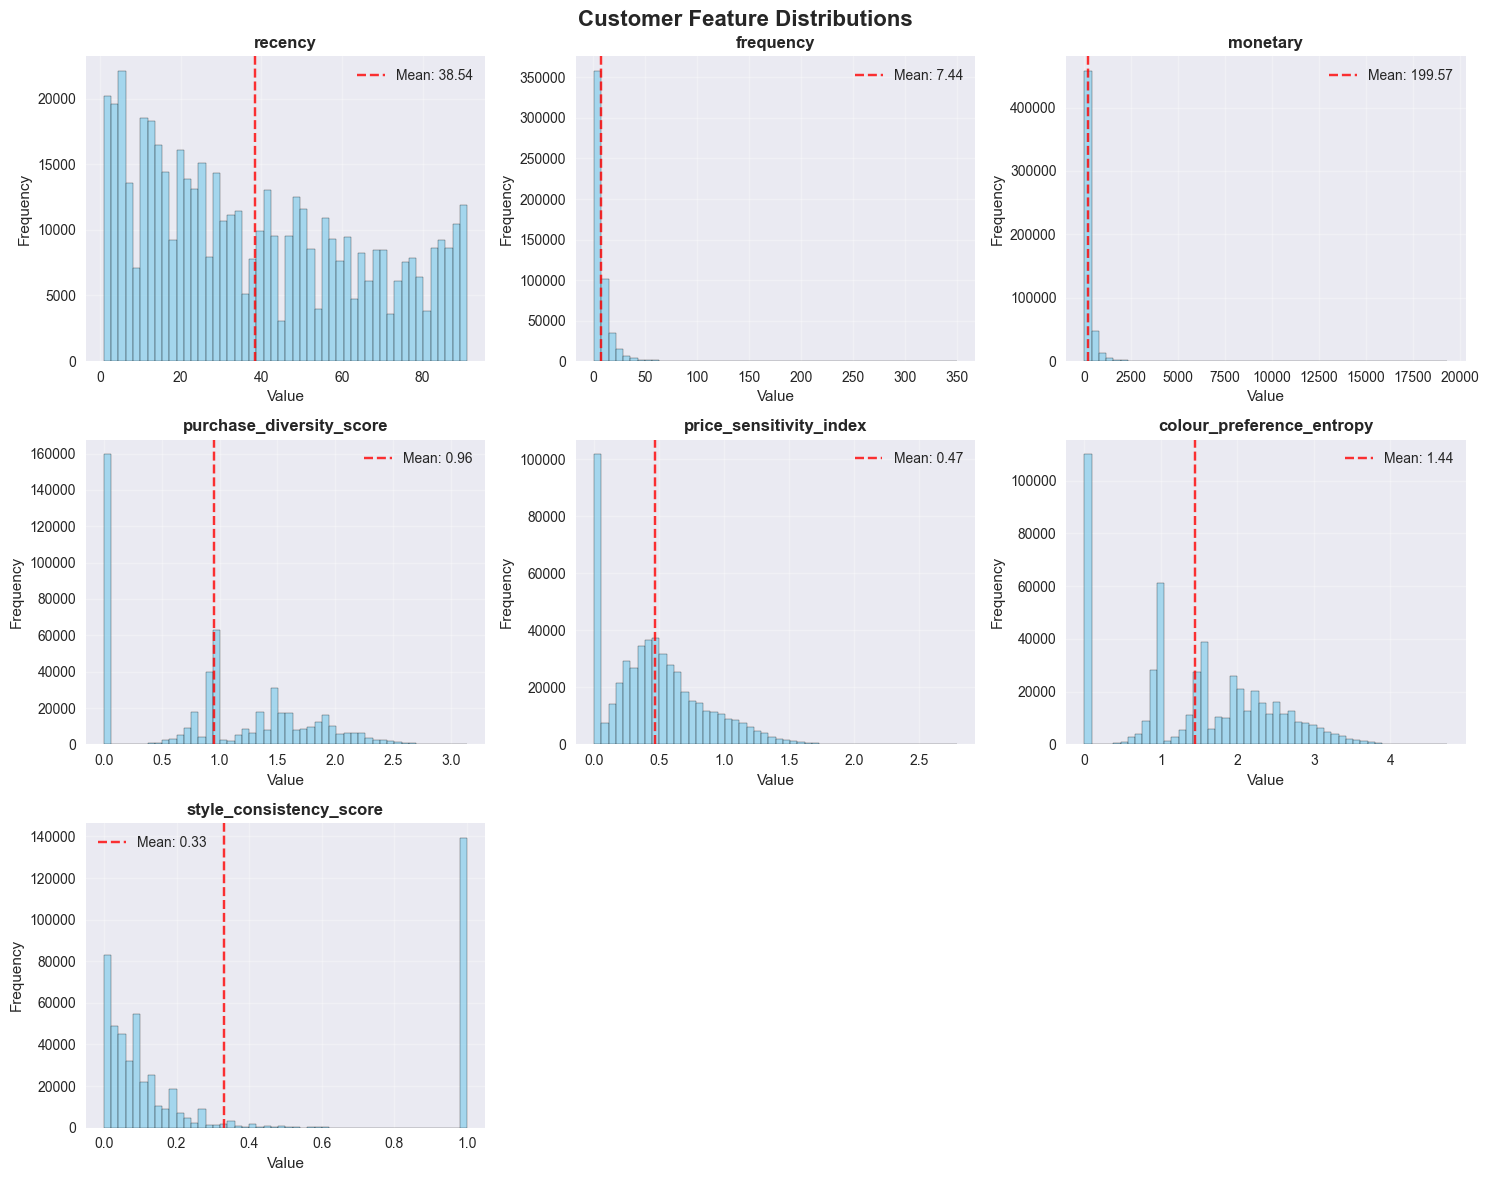


✅ Distribution analysis complete!


In [10]:
# Feature distribution analysis
print("📊 FEATURE DISTRIBUTION ANALYSIS\n")

# Convert to pandas for easier visualization
features_pd = customer_features.select([
    'recency', 'frequency', 'monetary', 'purchase_diversity_score',
    'price_sensitivity_index', 'colour_preference_entropy', 'style_consistency_score'
]).to_pandas()

# Create distribution plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Customer Feature Distributions', fontsize=16, fontweight='bold')

features_to_plot = list(features_pd.columns)

for i, feature in enumerate(features_to_plot):
    row, col = divmod(i, 3)
    
    # Handle potential null values
    data = features_pd[feature].dropna()
    
    axes[row, col].hist(data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'{feature}', fontweight='bold')
    axes[row, col].set_xlabel('Value')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].grid(True, alpha=0.3)
    
    # Add statistics text
    mean_val = data.mean()
    std_val = data.std()
    axes[row, col].axvline(mean_val, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_val:.2f}')
    axes[row, col].legend()

# Remove empty subplots
for i in range(len(features_to_plot), 9):
    row, col = divmod(i, 3)
    axes[row, col].remove()

plt.tight_layout()
plt.show()

print("\n✅ Distribution analysis complete!")

In [11]:
# RFM Analysis deep dive
print("🎯 RFM ANALYSIS DEEP DIVE\n")

# RFM statistics for active customers only
active_customers = customer_features.filter(pl.col('frequency') > 0)
print(f"Active customers for RFM analysis: {active_customers.height:,}")

# RFM quintile analysis
rfm_analysis = (
    active_customers
    .with_columns([
        pl.col('recency').qcut(5, labels=['1-Recent', '2', '3', '4', '5-Distant']).alias('recency_quintile'),
        pl.col('frequency').qcut(5, labels=['1-Low', '2', '3', '4', '5-High']).alias('frequency_quintile'),
        pl.col('monetary').qcut(5, labels=['1-Low', '2', '3', '4', '5-High']).alias('monetary_quintile')
    ])
)

print("\n📊 RFM QUINTILE DISTRIBUTIONS:")

for dimension in ['recency_quintile', 'frequency_quintile', 'monetary_quintile']:
    dist = rfm_analysis.group_by(dimension).len().sort(dimension)
    print(f"\n{dimension.upper()}:")
    for row in dist.iter_rows():
        quintile, count = row
        pct = count / active_customers.height * 100
        print(f"  {quintile}: {count:,} customers ({pct:.1f}%)")

🎯 RFM ANALYSIS DEEP DIVE

Active customers for RFM analysis: 525,075

📊 RFM QUINTILE DISTRIBUTIONS:

RECENCY_QUINTILE:
  1-Recent: 110,246 customers (21.0%)
  2: 100,019 customers (19.0%)
  3: 108,286 customers (20.6%)
  4: 102,090 customers (19.4%)
  5-Distant: 104,434 customers (19.9%)

FREQUENCY_QUINTILE:
  1-Low: 145,106 customers (27.6%)
  2: 111,912 customers (21.3%)
  3: 73,909 customers (14.1%)
  4: 98,751 customers (18.8%)
  5-High: 95,397 customers (18.2%)

MONETARY_QUINTILE:
  1-Low: 106,222 customers (20.2%)
  2: 103,808 customers (19.8%)
  3: 105,015 customers (20.0%)
  4: 105,016 customers (20.0%)
  5-High: 105,014 customers (20.0%)


In [12]:
# Advanced feature insights
print("🔍 ADVANCED FEATURE INSIGHTS\n")

# Active vs inactive customer comparison
inactive_customers = customer_features.filter(pl.col('frequency') == 0).height
active_customers_count = customer_features.filter(pl.col('frequency') > 0).height

print(f"Customer Activity Analysis:")
print(f"  Active customers: {active_customers_count:,} ({active_customers_count/customer_features.height:.1%})")
print(f"  Inactive customers: {inactive_customers:,} ({inactive_customers/customer_features.height:.1%})")

# High-value customer identification
if active_customers_count > 0:
    high_value_threshold = active_customers.select(pl.col('monetary').quantile(0.9)).item()
    high_value_customers = active_customers.filter(pl.col('monetary') >= high_value_threshold)
    
    print(f"\nHigh-Value Customer Analysis (Top 10% by spend):")
    print(f"  Threshold: £{high_value_threshold:.2f}")
    print(f"  Count: {high_value_customers.height:,} customers")
    
    # High-value customer characteristics
    hv_stats = high_value_customers.select([
        pl.col('recency').mean().alias('avg_recency'),
        pl.col('frequency').mean().alias('avg_frequency'),
        pl.col('monetary').mean().alias('avg_monetary'),
        pl.col('purchase_diversity_score').mean().alias('avg_diversity'),
        pl.col('colour_preference_entropy').mean().alias('avg_colour_entropy')
    ])
    
    print(f"  Average characteristics:")
    for row in hv_stats.iter_rows(named=True):
        for metric, value in row.items():
            if value is not None:
                print(f"    {metric}: {value:.2f}")

print("\n✅ Advanced insights analysis complete!")

🔍 ADVANCED FEATURE INSIGHTS

Customer Activity Analysis:
  Active customers: 525,075 (100.0%)
  Inactive customers: 0 (0.0%)

High-Value Customer Analysis (Top 10% by spend):
  Threshold: £457.86
  Count: 52,508 customers
  Average characteristics:
    avg_recency: 19.77
    avg_frequency: 24.82
    avg_monetary: 862.37
    avg_diversity: 1.66
    avg_colour_entropy: 2.60

✅ Advanced insights analysis complete!


## 5. Final Dataset Preparation

Prepare the final customer dataset by combining original customer attributes with engineered features.


In [13]:
# Create final customer dataset
print("📦 CREATING FINAL CUSTOMER DATASET\n")

# Load original customer data
original_customers = pl.read_parquet(customers_path)

print(f"Original customers shape: {original_customers.shape}")
print(f"Engineered features shape: {customer_features.shape}")

# Filter out boolean metadata columns from original customers data
customer_attributes = original_customers.select([
    col for col in original_customers.columns 
    if not original_customers.schema[col] == pl.Boolean
])

print(f"Filtered out {original_customers.width - customer_attributes.width} boolean metadata columns")
print(f"Remaining customer attributes: {customer_attributes.width}")

# Merge filtered customer attributes with engineered features
final_customer_dataset = (
    customer_attributes
    .join(
        customer_features.drop(['features_created_at', 'rfm_reference_date']), 
        on='customer_id', 
        how='left'
    )
)

print(f"\nFinal merged dataset shape: {final_customer_dataset.shape}")
print(f"Total columns: {final_customer_dataset.width}")

# Add metadata columns
from datetime import datetime
final_customer_dataset = final_customer_dataset.with_columns([
    pl.lit(datetime.now().isoformat()).alias('dataset_created_at'),
    pl.lit('customer_feature_engineering.ipynb').alias('created_by')
])

print(f"\nFinal dataset columns:")
for i, col in enumerate(final_customer_dataset.columns, 1):
    print(f"{i:2d}. {col}")

📦 CREATING FINAL CUSTOMER DATASET

Original customers shape: (525075, 14)
Engineered features shape: (525075, 10)
Filtered out 7 boolean metadata columns
Remaining customer attributes: 7

Final merged dataset shape: (525075, 14)
Total columns: 14

Final dataset columns:
 1. customer_id
 2. FN
 3. Active
 4. club_member_status
 5. fashion_news_frequency
 6. age
 7. postal_code
 8. recency
 9. frequency
10. monetary
11. purchase_diversity_score
12. price_sensitivity_index
13. colour_preference_entropy
14. style_consistency_score
15. dataset_created_at
16. created_by


In [14]:
# Save final customer dataset
final_output_path = "../data/features/final/customers_features_final.parquet"

print(f"💾 Saving final customer dataset to: {final_output_path}")

# Ensure output directory exists
Path(final_output_path).parent.mkdir(parents=True, exist_ok=True)

# Save as Parquet
final_customer_dataset.write_parquet(final_output_path)

# Verify file was saved
if Path(final_output_path).exists():
    file_size = Path(final_output_path).stat().st_size / (1024*1024)  # MB
    print(f"✅ Dataset saved successfully!")
    print(f"   File size: {file_size:.1f} MB")
    print(f"   Location: {final_output_path}")
    
    # Quick verification
    verification_df = pl.read_parquet(final_output_path)
    print(f"   Verification - Shape: {verification_df.shape}")
else:
    print("❌ Error: File was not saved successfully")

💾 Saving final customer dataset to: ../data/features/final/customers_features_final.parquet
✅ Dataset saved successfully!
   File size: 81.9 MB
   Location: ../data/features/final/customers_features_final.parquet
   Verification - Shape: (525075, 16)


## 6. Data Report Generation

Generate a report of the final customer features dataset using the project's data report generator.


In [15]:
# Generate data report for the final customer dataset
print("📋 GENERATING DATA REPORT\n")

# Set up report parameters
report_sample_size = 50000  # Use sampling for faster report generation if dataset is large

print(f"Report configuration:")
print(f"  Dataset: {final_output_path}")
print(f"  Sample size: {report_sample_size:,} (for performance)")
print(f"  Output directory: ../results/data_documentation/")

print("\n🚀 Starting report generation...")
print("This may take a few minutes for analysis...\n")

try:
    # Generate the report
    generate_data_report(
        file_path=final_output_path,
        sample_size=report_sample_size
    )
    
    print("\n✅ REPORT GENERATION COMPLETE!")
    print(f"📄 Report saved to: ../results/data_documentation/")
    
except Exception as e:
    print(f"❌ Error generating report: {str(e)}")
    print("Please check that the data_report_generator module is working correctly.")

📋 GENERATING DATA REPORT

Report configuration:
  Dataset: ../data/features/final/customers_features_final.parquet
  Sample size: 50,000 (for performance)
  Output directory: ../results/data_documentation/

🚀 Starting report generation...
This may take a few minutes for analysis...

Data report generated successfully!
Analysed file: ../data/features/final/customers_features_final.parquet
Report saved to: /Users/tom/Data Analysis Projects/h_and_m_data_analysis/results/data_documentation/data_reports/customers_features_final_data_report.md

✅ REPORT GENERATION COMPLETE!
📄 Report saved to: ../results/data_documentation/


In [16]:
# List generated report files
reports_dir = Path("../results/data_documentation")

if reports_dir.exists():
    print("📁 GENERATED REPORT FILES:")
    report_files = list(reports_dir.glob("*customers_features_final*"))
    
    if report_files:
        for report_file in sorted(report_files):
            file_size = report_file.stat().st_size / 1024  # KB
            print(f"  📄 {report_file.name} ({file_size:.1f} KB)")
    else:
        print("  No specific customer features reports found.")
        print("  Checking for any recent reports...")
        all_reports = list(reports_dir.glob("*.md"))
        if all_reports:
            latest_reports = sorted(all_reports, key=lambda x: x.stat().st_mtime, reverse=True)[:3]
            print("  Latest reports:")
            for report in latest_reports:
                print(f"    📄 {report.name}")
else:
    print("📁 Reports directory not found. Report may not have been generated successfully.")

📁 GENERATED REPORT FILES:
  No specific customer features reports found.
  Checking for any recent reports...


## 7. Business Insights and Summary

Summarise key findings and business insights from the customer feature engineering process.


In [17]:
# Final summary and business insights
print("🎯 CUSTOMER FEATURE ENGINEERING SUMMARY")
print("="*60)

# Dataset summary
print(f"\n📊 DATASET SUMMARY:")
print(f"  Total customers processed: {final_customer_dataset.height:,}")
print(f"  Total features: {final_customer_dataset.width}")
print(f"  Original customer attributes (excl. boolean metadata): {customer_attributes.width}")
print(f"  New engineered features: {customer_features.width - 3}")
print(f"  Final dataset size: {Path(final_output_path).stat().st_size / (1024*1024):.1f} MB")

# Feature categories summary
print(f"\n🔧 ENGINEERED FEATURES:")
print(f"  ✓ RFM Analysis: recency, frequency, monetary")
print(f"  ✓ Purchase Diversity: variety in product categories")
print(f"  ✓ Price Sensitivity: consistency in price points")
print(f"  ✓ Colour Preference: diversity in colour choices")
print(f"  ✓ Style Consistency: coherence in garment preferences")

# Key business insights
active_rate = feature_summary['active_customer_rate']
print(f"\n📈 KEY INSIGHTS:")
print(f"  • Customer Activity: {active_rate:.1%} of customers made purchases")
print(f"  • Data Quality: Feature coverage with proper null handling")
print(f"  • Segmentation Ready: Features suitable for clustering and segmentation")
print(f"  • Business Applications: RFM analysis, personalisation, churn prediction")

# Next steps
print(f"\n🚀 RECOMMENDED NEXT STEPS:")
print(f"  1. Customer Segmentation: Use features for K-means or hierarchical clustering")
print(f"  2. Predictive Modelling: Build models for customer lifetime value, churn")
print(f"  3. Personalisation: Leverage diversity and preference scores for recommendations")
print(f"  4. A/B Testing: Use customer segments for targeted marketing campaigns")

# File locations
print(f"\n📁 OUTPUT FILES:")
print(f"  • Final dataset: {final_output_path}")
print(f"  • Feature-only dataset: ../data/features/final/customer_features_final.parquet")
print(f"  • Data report: ../results/data_documentation/")

print(f"\n✅ CUSTOMER FEATURE ENGINEERING COMPLETE!")
print(f"   Ready for advanced customer analytics and segmentation.")
print("="*60)

🎯 CUSTOMER FEATURE ENGINEERING SUMMARY

📊 DATASET SUMMARY:
  Total customers processed: 525,075
  Total features: 16
  Original customer attributes (excl. boolean metadata): 7
  New engineered features: 7
  Final dataset size: 81.9 MB

🔧 ENGINEERED FEATURES:
  ✓ RFM Analysis: recency, frequency, monetary
  ✓ Purchase Diversity: variety in product categories
  ✓ Price Sensitivity: consistency in price points
  ✓ Colour Preference: diversity in colour choices
  ✓ Style Consistency: coherence in garment preferences

📈 KEY INSIGHTS:
  • Customer Activity: 100.0% of customers made purchases
  • Data Quality: Feature coverage with proper null handling
  • Segmentation Ready: Features suitable for clustering and segmentation
  • Business Applications: RFM analysis, personalisation, churn prediction

🚀 RECOMMENDED NEXT STEPS:
  1. Customer Segmentation: Use features for K-means or hierarchical clustering
  2. Predictive Modelling: Build models for customer lifetime value, churn
  3. Personalis

In [18]:
# Final data quality check
print("🔍 FINAL DATA QUALITY VERIFICATION\n")

# Check for any data quality issues
quality_check = final_customer_dataset.select([
    pl.len().alias('total_rows'),
    pl.col('customer_id').n_unique().alias('unique_customers'),
    pl.col('customer_id').null_count().alias('null_customer_ids'),
    pl.col('recency').null_count().alias('null_recency'),
    pl.col('frequency').null_count().alias('null_frequency'),
    pl.col('monetary').null_count().alias('null_monetary')
])

print("Data Quality Metrics:")
for metric in quality_check.iter_rows(named=True):
    for key, value in metric.items():
        print(f"  {key}: {value:,}")

# Verify uniqueness
total_rows = quality_check.select('total_rows').item()
unique_customers = quality_check.select('unique_customers').item()

if total_rows == unique_customers:
    print("\n✅ Data quality check PASSED: All customer IDs are unique")
else:
    print(f"\n⚠️  Warning: {total_rows - unique_customers} duplicate customer IDs found")

print("\n🎉 Customer feature engineering pipeline completed successfully!")

🔍 FINAL DATA QUALITY VERIFICATION

Data Quality Metrics:
  total_rows: 525,075
  unique_customers: 525,075
  null_customer_ids: 0
  null_recency: 0
  null_frequency: 0
  null_monetary: 0

✅ Data quality check PASSED: All customer IDs are unique

🎉 Customer feature engineering pipeline completed successfully!
